In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import segmentation_models as sm
import gc
from pipeline import Pipeline
import matplotlib.pyplot as plt
from tqdm import tqdm



2023-05-19 13:07:44.982994: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.


Segmentation Models: using `keras` framework.


##### Put this in pipeline.py

In [2]:

# def predict_and_assemble(self, volume, mask, threshold, model):
#     test_a_ds = self.make_iterated_data_generator(volume, mask)
#     locations = self.list_all_locations(mask)
#     all_pred = np.zeros(mask.shape)
#     all_binary_pred = np.zeros(mask.shape)
#     pred = []

#     for i, patch in tqdm(enumerate(test_a_ds())):
#         # pred[i]: (128, 128, 1)
#         p = model.predict(np.expand_dims(patch, 0))[0]
#         pred.append(p)
#         c = locations[i]
#         l = c[0] - self.patch_halfsize
#         r = c[0] + self.patch_halfsize
#         t = c[1] + self.patch_halfsize
#         b = c[1] - self.patch_halfsize
#         p = p.squeeze()
#         all_pred[l:r, b:t] = p
#         p = p > threshold
#         all_binary_pred[l:r, b:t] = p

#     return all_pred, all_binary_pred, pred


## Load the test set, build the pipeline

In [3]:
data_dir = "./dataset/"
patch_size = 800  # e.g. 128x128
downsampling = 1  # setting this to e.g. 0.5 means images will be loaded as 2x smaller. 1 does nothing.
z_dim = 40   # number of slices in the z direction. max value is 65 - z_start
z_start = 0  # offset of slices in the z direction
batch_size = 4
epochs = 100
steps_per_epoch = 50
val_step = 50

pipeline = Pipeline(data_dir, patch_size, downsampling, z_dim, z_start, batch_size)
volume_a, mask_a, _ = pipeline.load_sample(split="test", index='a')
volume_b, mask_b, _ = pipeline.load_sample(split="test", index='b')
# volume_3, mask_3, labels_3 = pipeline.load_sample(split="train", index='3')
# volume_3 = sm.get_preprocessing('resnet18')(volume_3)
# volume_1, mask_1, labels_1 = pipeline.load_sample(split="train", index='1')
# volume_1 = sm.get_preprocessing('resnet18')(volume_1)


gc.collect()
print("Loading complete.")

Loading 'test/a'...


100%|██████████| 4/4 [00:00<00:00, 14.24it/s]


Loading 'test/b'...


100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


Loading complete.


In [4]:
# print(f"volume_a: {volume_a.shape}")
# print(f"mask_a: {mask_a.shape}")

In [5]:
model = sm.Unet(
    'resnet18',
    input_shape=pipeline.get_input_shape(),
    encoder_weights=None,
    classes=1
)
model.load_weights('chkpt-resnet/resnet18-800p-4b-chkpt/checkpoint')

2023-05-19 13:08:14.837049: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-05-19 13:08:15.209644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-19 13:08:15.209825: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2023-05-19 13:08:15.209857: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2023-05-19 13:08:15.212794: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2023-05-19 13:08:15.214088: I tensorflow/stream_executor/plat

In [6]:
# threshold = 0.5
# all_pred, all_binary_pred, pred = pipeline.predict_and_assemble(volume_a, mask_a, threshold, model)

In [7]:
# test_a_ds = pipeline.make_iterated_data_generator(volume_3, mask_3, labels_3)
# fig, ax = plt.subplots(1, 2)
# for i, patch in tqdm(enumerate(test_a_ds())):
#     # pred[i]: (128, 128, 1)
#     patch, labels = patch
#     p = model.predict(np.expand_dims(patch, 0))[0]
#     p = p.squeeze()
#     p_b = p > threshold
#     ax[0].imshow(p_b)
#     ax[0].set_title("prediction")
#     ax[1].imshow(labels)
#     ax[1].set_title("ground truth")
#     fig.savefig(f'imgs/{i}.png')

In [8]:
threshold = 0.4
# all_pred, all_binary_pred, pred = pipeline.predict_and_assemble(volume_3, mask_3, threshold, model)
# all_pred, all_binary_pred, pred = pipeline.predict_and_assemble(volume_1, mask_1, threshold, model)
all_pred_a, all_binary_pred_a, pred_a = pipeline.predict_and_assemble(volume_a, mask_a, threshold, model)
all_pred_b, all_binary_pred_b, pred_b = pipeline.predict_and_assemble(volume_b, mask_b, threshold, model)

0it [00:00, ?it/s]2023-05-19 13:08:17.761479: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.8
2023-05-19 13:08:18.659477: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
47it [00:11,  4.09it/s]
102it [00:20,  4.93it/s]


## Plot the result

In [9]:
# mask
# plt.imshow(mask_a, cmap='gray')
# plt.imshow(mask_3, cmap='gray')

In [10]:
# plt.imshow(labels_3,cmap='gray')
# plt.imshow(labels_1,cmap='gray')

In [11]:
# binary predictions
# plt.imshow(all_binary_pred, cmap='gray')

In [12]:
# non-binary predictions
# plt.imshow(all_pred, cmap='gray')

In [13]:
threshold = 0.95
# plt.imshow(all_pred>threshold, cmap='gray')
# plt.savefig(f'resnet18-800p-4b-50epoch-threshold-{threshold}-volume-3.svg')

In [14]:
# threshold=0.95
# fig, axs = plt.subplots(1,3, figsize=(10,3))
# axs[0].imshow(labels_3,cmap='gray')
# axs[0].set_title("Ground Truth")
# axs[1].imshow(all_pred,cmap='gray')
# axs[1].set_title("Predictions")
# axs[2].imshow(all_pred>threshold,cmap='gray')
# axs[2].set_title(f'Binary Predictions')
# plt.savefig(f'resnet18-800p-4b-50epoch-threshold-{threshold}-volume-3-compare.svg')


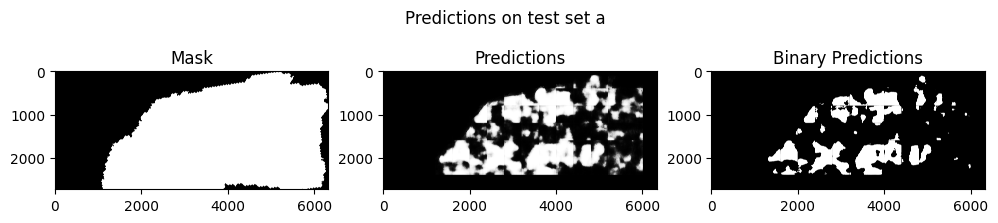

In [21]:
threshold=0.95
fig, axs = plt.subplots(1,3, figsize=(12,2.5))
axs[0].imshow(mask_a,cmap='gray')
axs[0].set_title("Mask")
axs[1].imshow(all_pred_a,cmap='gray')
axs[1].set_title("Predictions")
axs[2].imshow(all_pred_a>threshold,cmap='gray')
axs[2].set_title(f'Binary Predictions')
fig.suptitle("Predictions on test set a")
plt.savefig(f'resnet18-800p-4b-50epoch-threshold-{threshold}-test-a-compare.svg')


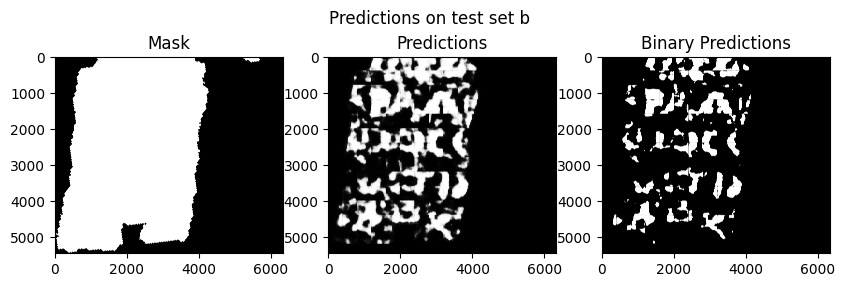

In [22]:
threshold=0.95
fig, axs = plt.subplots(1,3, figsize=(10,3))
axs[0].imshow(mask_b,cmap='gray')
axs[0].set_title("Mask")
axs[1].imshow(all_pred_b,cmap='gray')
axs[1].set_title("Predictions")
axs[2].imshow(all_pred_b>threshold,cmap='gray')
axs[2].set_title(f'Binary Predictions')
fig.suptitle("Predictions on test set b")
plt.savefig(f'resnet18-800p-4b-50epoch-threshold-{threshold}-test-b-compare.svg')


## Submission file

In [30]:
def rle(output):
    flat_img = np.where(output.flatten() > 0.95, 1, 0).astype(np.uint8)
    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))

In [31]:
submission = defaultdict(list)

submission["Id"].append("a")
submission["Predicted"].append(rle(all_pred_a))
submission["Id"].append("b")
submission["Predicted"].append(rle(all_pred_b))

pd.DataFrame.from_dict(submission).to_csv("submission/submission.csv", index=False)

In [33]:
df = pd.DataFrame.from_dict(submission)
df

,Id,Predicted
0,a,688508 8 694835 14 701162 19 707491 22 713820 ...
1,b,9751 27 14003 88 15191 79 15925 300 20321 110 ...
